In [60]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import skew, kurtosis
import os
import random
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy.fftpack import fft, fftfreq
from scipy.signal import peak_widths, peak_prominences
from scipy.io import loadmat
import seaborn as sns
from scipy.signal import spectrogram

## Fetch signals from folder

In [40]:
SIGLEN = 65536

# splits a signal, arr, into n equal parts (last part padded with zero in case of remainder)
def windowize(arr, n):
    remainder = len(arr) % n
    arr_padded = arr
    if remainder:
        padding_size = n - remainder
        arr_padded = np.concatenate((arr, np.zeros(padding_size)))

    # array after padding
    arr = arr_padded
    array_length = len(arr)
    subarray_size = int(array_length // n)
    subarrays = [arr[i:i + subarray_size] for i in range(0, array_length, subarray_size)]

    return subarrays


# This method is sensor direction and location agnostic -- DEPRECATED
def fetch_signals(root, window_size = 16384, train = True, train_split = 0.2):
    """
    window_size: length of a subdivision of original signal (6000 samples * (1/100) seconds/samples = 60 second sample)
    train: if True, then get training portion of data
    train_split: what proportion to use as training data (by default one third)
    """
    from scipy.io import loadmat
    signals = []
    folder_path = root
    file_list = os.listdir(folder_path)
    labels = []

    # for determinism
    random.seed(10)
    
    # walk inside data folder
    for filename in file_list:
        full_path = os.path.join(folder_path, filename)
        cur_label = int(filename)

        # walk inside data/[number]
        file_nest_list = os.listdir(full_path)
        for filename_1 in file_nest_list:
            if filename_1 != "avt":
                continue
            else:
                # full_path_2 is of the form C:\Users\amroa\Documents\thesis\data\01\avt
                full_path_2 = os.path.join(full_path, filename_1)
                setup_filenames = [filename for filename in os.listdir(full_path_2) if "setup" in filename]
                if train:
                    # take train_split percent of data
                    train_files = setup_filenames[0:int(len(setup_filenames)*train_split)]

                    # iterate through them
                    for file_train in train_files:
                        full_path_3 = os.path.join(full_path_2, file_train) # full_path_3 is of the form C:\Users\amroa\Documents\thesis\data\01\avt\01setup09.mat
                        
                        avt = loadmat(full_path_3)
                        avt_t = avt['data'].transpose()

                        # pad every signal to length 65536
                        padded_avt = [np.pad(arr, (0, SIGLEN - len(arr)), 'constant') for arr in avt_t]
                        avt_t = padded_avt

                        #split the signal into smaller signals of sample size window_size 
                        windows = [windowize(avt_t[i], int(len(avt_t[i])/window_size)) for i in range(len(avt_t))]
                        [[(signals.append(i), labels.append(cur_label)) for i in window] for window in windows] 
                else:
                    # take test_split percent of data
                    test_files = setup_filenames[int(len(setup_filenames)*train_split):]

                    # iterate through them
                    for file_test in test_files:
                        full_path_3 = os.path.join(full_path_2, file_test) # full_path_3 is of the form C:\Users\amroa\Documents\thesis\data\01\avt\01setup09.mat
                        
                        avt = loadmat(full_path_3)
                        avt_t = avt['data'].transpose()

                        # pad every signal to length 65536
                        padded_avt = [np.pad(arr, (0, SIGLEN - len(arr)), 'constant') for arr in avt_t]
                        avt_t = padded_avt

                        # split the signal into smaller signals of sample size window_size 
                        windows = [windowize(avt_t[i], int(len(avt_t[i])/window_size)) for i in range(len(avt_t))]
                        [[(signals.append(i), labels.append(cur_label)) for i in window] for window in windows] 
    return signals, labels



In [269]:
signals, labels = fetch_signals('C:\\Users\\amroa\\Documents\\thesis\\data', window_size = 16384, train = True, train_split = 0.5)

## Sample visualization for one signal

dict_keys(['__header__', '__version__', '__globals__', 'data', 'labelshulp']) ['99V ' '100V' '101V' '102V' '103V' '199L' '199T' '199V' '200T' '200V'
 '201T' '201V' '202T' '202V' '203L' '203T' '203V' '299V' '300V' '301V'
 '302V' '303V' '511L' '511T' '511V' '512L' '512T' '512V' 'R1V ' 'R2L '
 'R2T ' 'R2V ' 'R3V '] ['109V' '110V' '111V' '112V' '113V' '209L' '209T' '209V' '210T' '210V'
 '211T' '211V' '212T' '212V' '213L' '213T' '213V' '309V' '310V' '311V'
 '312V' '313V' '531L' '531T' '531V' '532L' '532T' '532V' 'R1V ' 'R2L '
 'R2T ' 'R2V ' 'R3V ']


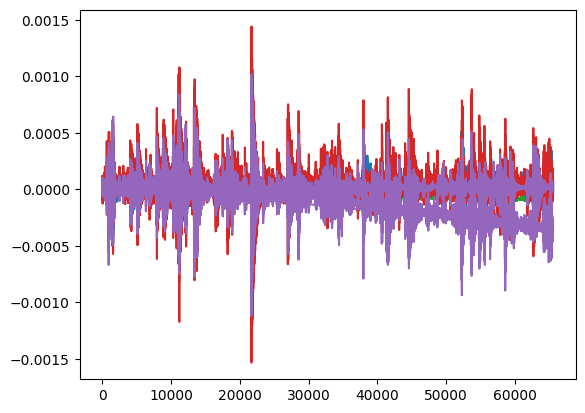

In [339]:
## sampling rate of 100 Hz at 65,536 samples
avt = loadmat('./data/01/avt/01setup01.mat')
avt3 = loadmat('./data/01/avt/01setup03.mat')
print(avt.keys(),avt[ 'labelshulp'],avt3[ 'labelshulp'])

plt.plot(pd.concat((pd.DataFrame(avt['data'],columns = avt[ 'labelshulp']),
pd.DataFrame(avt3['data'],columns = avt3[ 'labelshulp'])))[[ 'R1V ', 'R2L ','R2T ', 'R2V ', 'R3V ']])

In [21]:
avt_data = avt['data'].transpose()

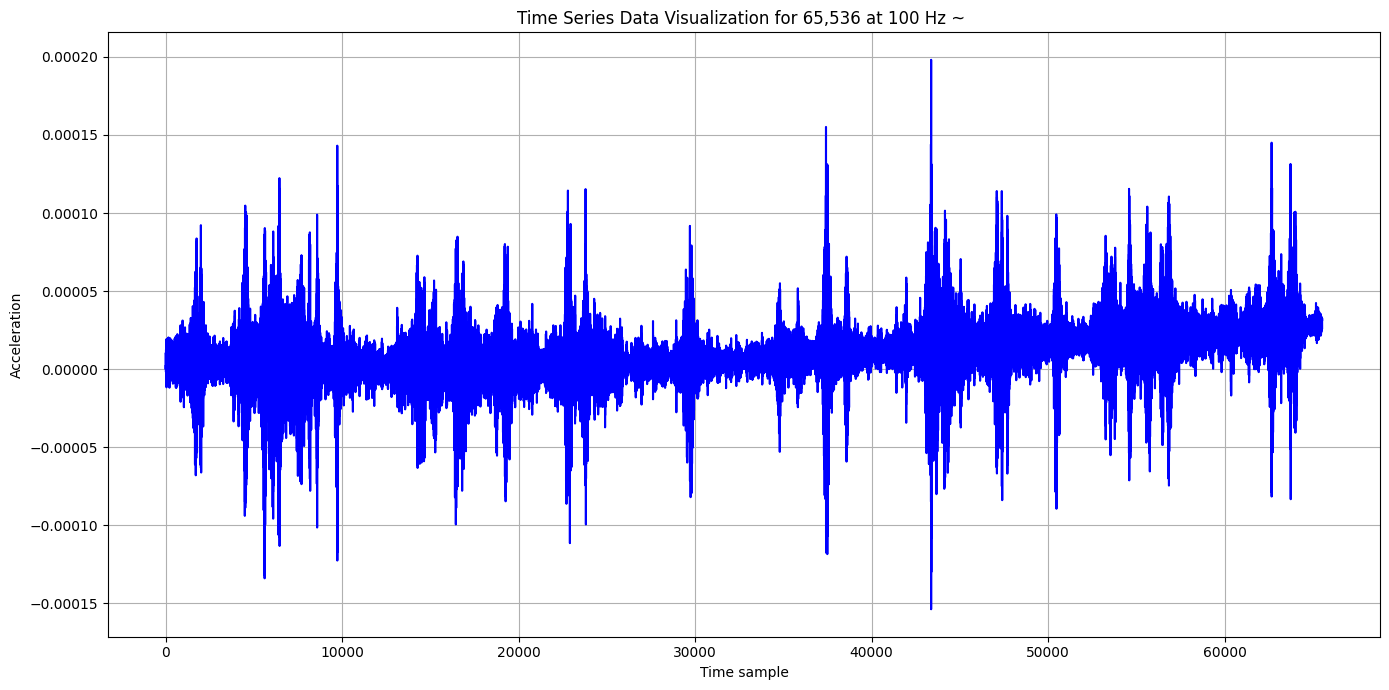

In [77]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Visualize the data
plt.figure(figsize=(14,7))
plt.plot(avt_data[29], label='Time Series Data', color='blue')
plt.title('Time Series Data Visualization for 65,536 at 100 Hz ~ ')
plt.xlabel('Time sample')
plt.ylabel('Acceleration')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
from scipy.stats import skew, kurtosis
import numpy as np

def sample_statistics(arr):
    return (np.min(arr), np.max(arr), np.std(arr), skew(arr), kurtosis(arr, fisher = True))

In [44]:
print(sample_statistics(avt_data[29]))
signal = avt_data[29]
print(len(signal))

(-0.000153717, 0.0001981506, 1.725628057927793e-05, -0.03599096315671912, 5.458318716265071)
65536


### Remove constant offset from the signal

In [45]:
def remove_dc_component(signal):
    dc_removed_signal = signal - np.mean(signal)
    return dc_removed_signal

### Bandpass filter between 1 and 30 Hz

In [363]:
from scipy.signal import butter, lfilter,filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=6):
    """
    Design and apply a Butterworth bandpass filter.
    Parameters:
        data (array): The signal to be filtered.
        lowcut (float): The lower frequency cut-off.
        highcut (float): The higher frequency cut-off.
        fs (int): The sampling rate of the data.
        order (int, optional): Order of the Butterworth filter. Default is 6.
    Returns:
        array: Filtered data.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

### Detrending 

In [50]:
from scipy.signal import detrend
def detrended_signal(filtered_signal):
    return detrend(filtered_signal)

### Standardization

In [48]:
def standardize_signal(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    standard_signal = (signal - mean_signal) / std_signal
    return standard_signal

In [54]:
def preprocess(signal): # type: ignore
    low = 1 
    high  = 30
    sample_rate = 100
    return standardize_signal(bandpass_filter(remove_dc_component(detrended_signal(signal)), low, high, sample_rate))

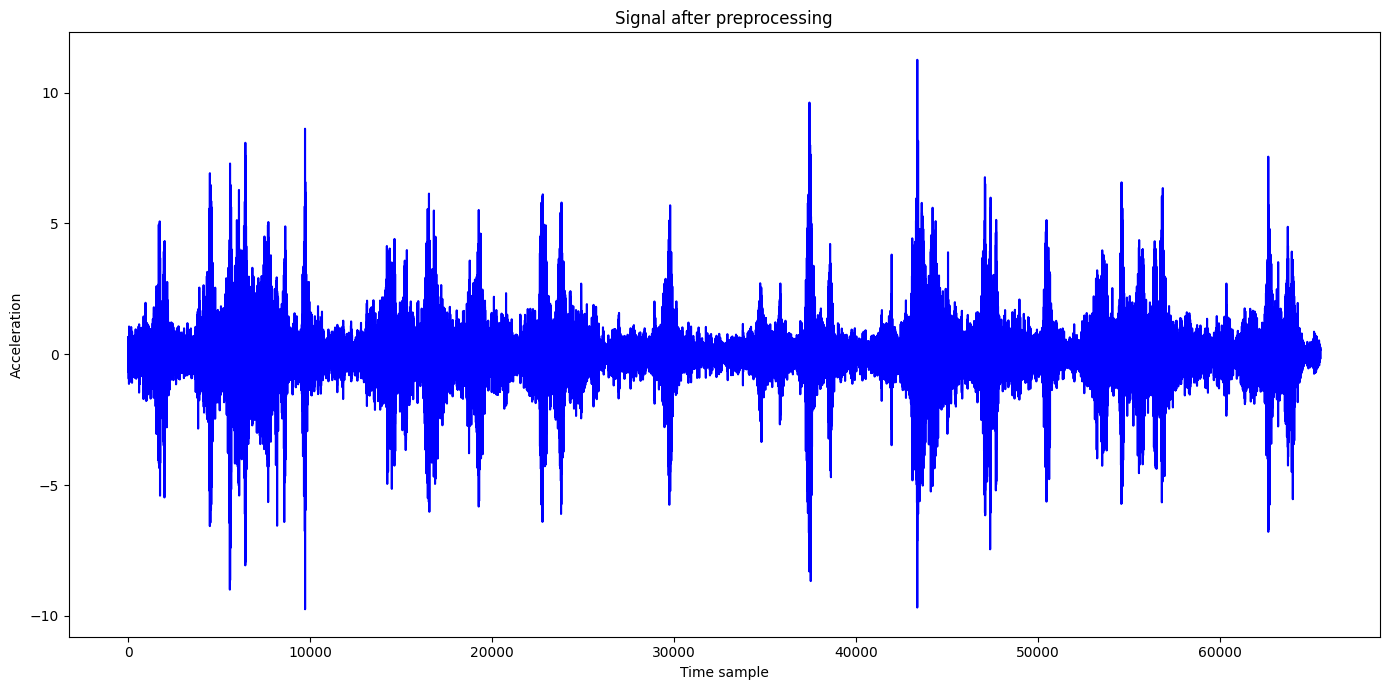

In [76]:
plt.figure(figsize=(14,7))
plt.plot(preprocess(avt_data[29]), label='Time Series Data', color='blue')
plt.title('Signal after preprocessing')
plt.xlabel('Time sample')
plt.ylabel('Acceleration')
plt.tight_layout()
plt.show()

## Signal Smoothing (Window of size 2.7 minutes ~ 16384 samples)

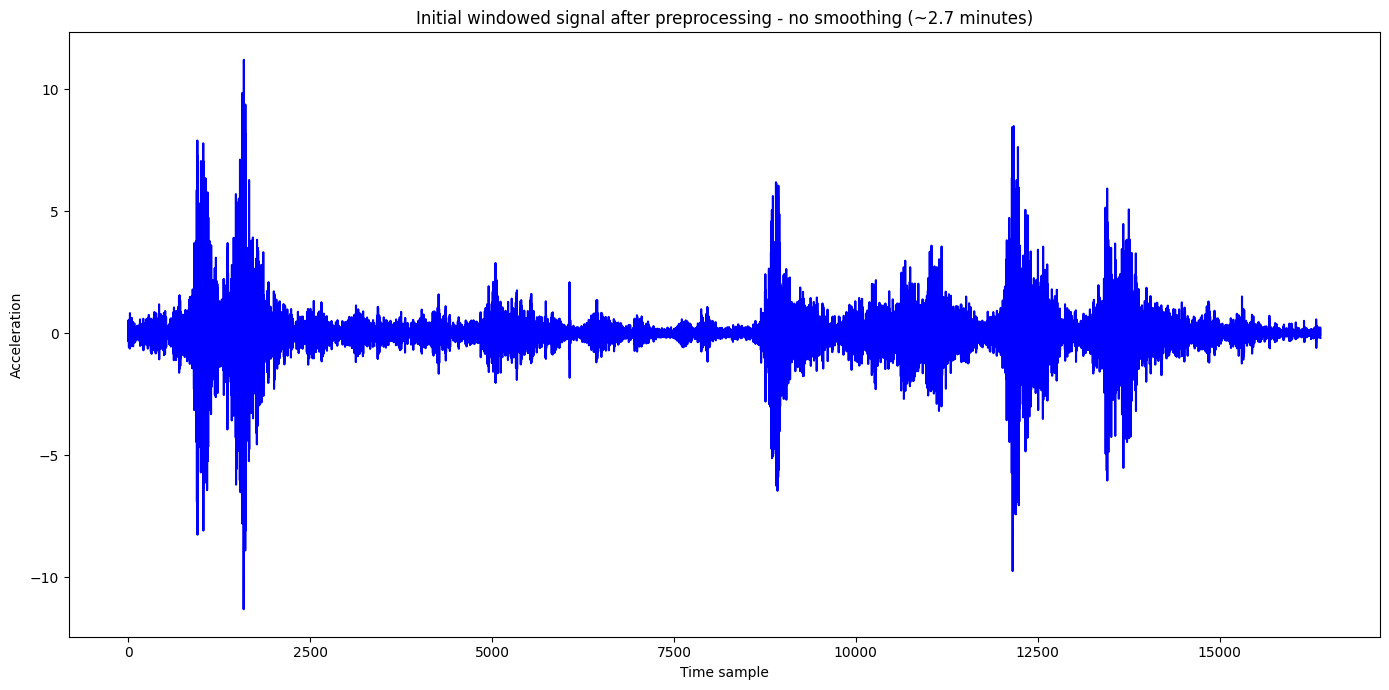

In [90]:
plt.figure(figsize=(14,7))
plt.plot(preprocess(signals[0]), label='Time Series Data', color='blue')
plt.title('Initial windowed signal after preprocessing - no smoothing (~2.7 minutes)')
plt.xlabel('Time sample')
plt.ylabel('Acceleration')
plt.tight_layout()
plt.show()

### Moving average smoothing

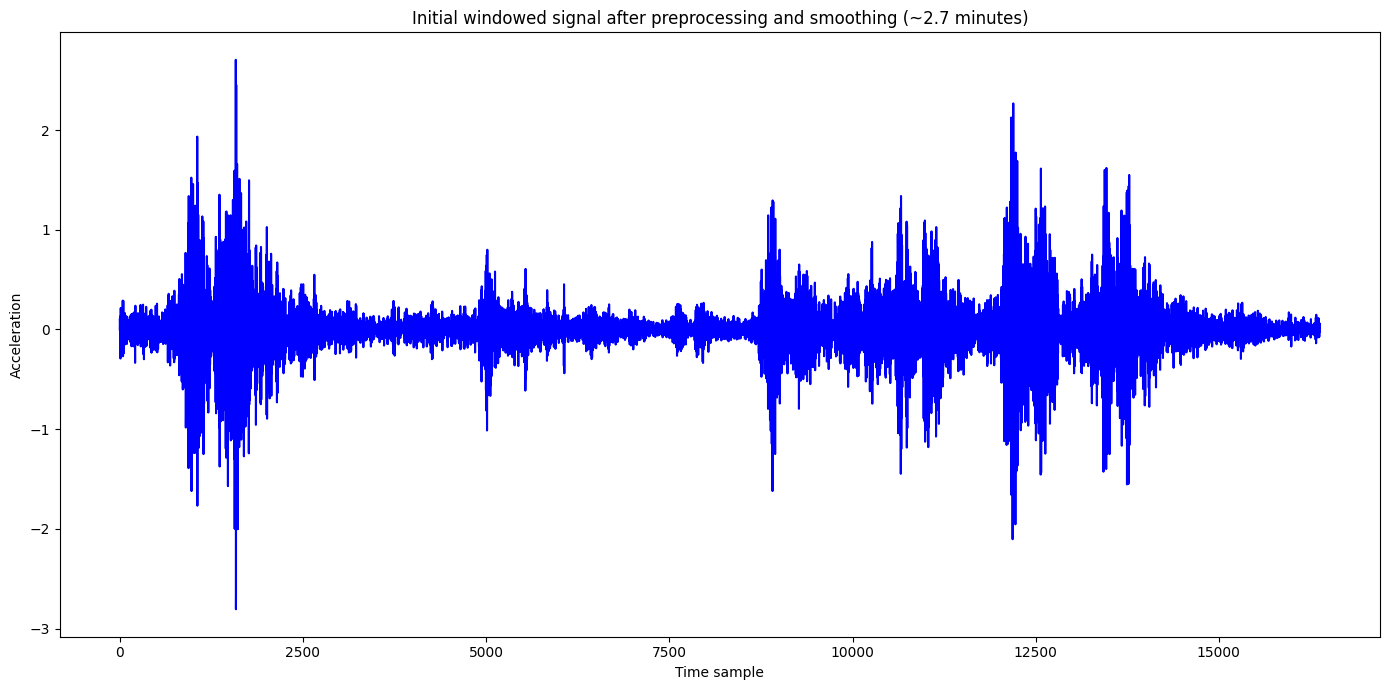

In [163]:
# Smoothing function based on moving averages of length 3
def moving_average(a, n=4):
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=(14,7))
plt.plot(moving_average(preprocess(signals[0])), label='Time Series Data', color='blue')
plt.title('Initial windowed signal after preprocessing and smoothing (~2.7 minutes)')
plt.xlabel('Time sample')
plt.ylabel('Acceleration')
plt.tight_layout()
plt.show()

### Savitzky Golay smoothing (repeated polynomial regression on windows)

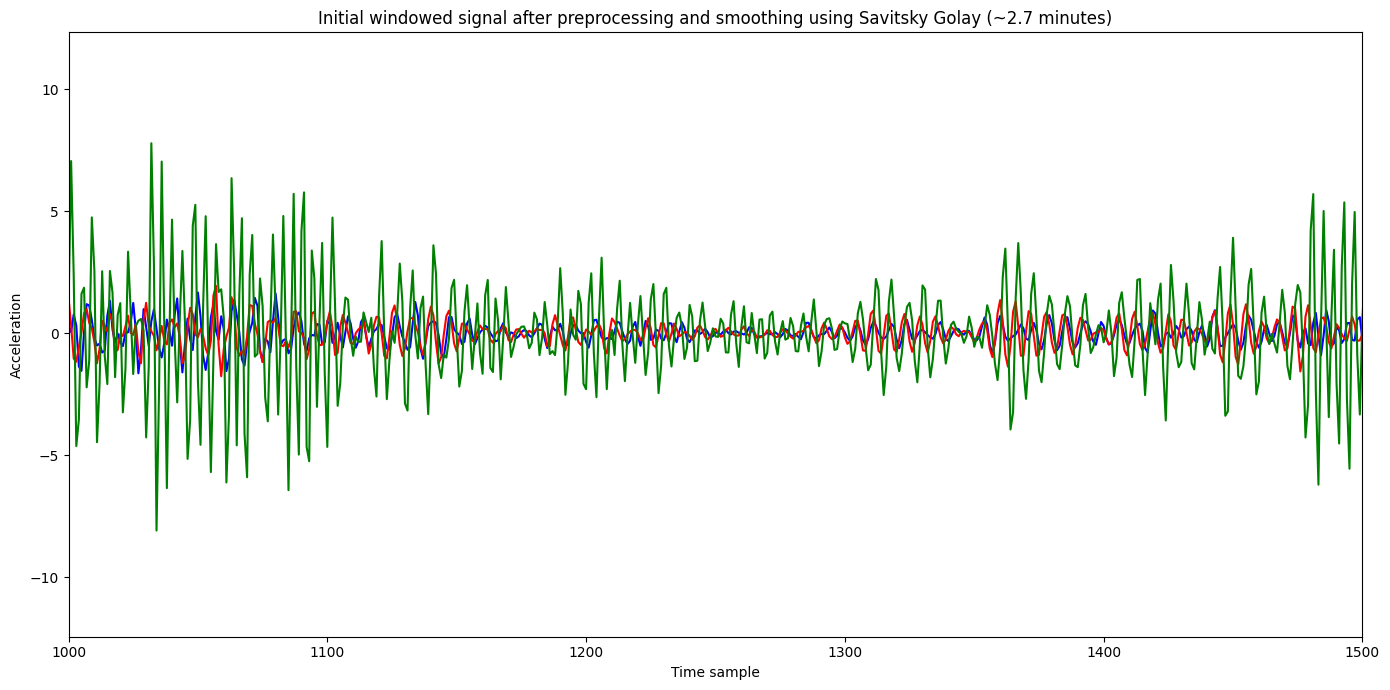

In [344]:
from scipy.signal import savgol_filter
plt.figure(figsize=(14,7))
plt.plot(savgol_filter(preprocess(signals[0]), 14, 4), label='SG', color='blue')
plt.plot(moving_average(preprocess(signals[0])), label='MA', color='red')
plt.plot(preprocess(signals[0]), label='MA', color='green')
plt.title('Initial windowed signal after preprocessing and smoothing using Savitsky Golay (~2.7 minutes)')
plt.xlabel('Time sample')
plt.ylabel('Acceleration')
plt.xlim(1000,1500)
plt.tight_layout()
plt.show()

In [1]:
# FFT plot 
signal = preprocess(signals[2])
n = len(signal)
frequencies = np.fft.fftfreq(n, 1/fs)[:n//2]
yf = fft(signal)

# Fundamental freq.
fundamental_frequency = frequencies[np.argmax(np.abs(yf))]

# Amplitude Spectrum
amplitude_spectrum = np.abs(yf)[:n//2]

plt.figure()
plt.plot(frequencies, amplitude_spectrum)
plt.yscale('log')
plt.xlim(0,10)


print(signal.shape)
from scipy.signal import welch

plt.figure()
signal = preprocess(signals[0])
f, Pxx_den = welch(signal, fs,nperseg= 3000)
plt.semilogy(f, Pxx_den)
signal = preprocess(signals[600])
f, Pxx_den = welch(signal, fs,nperseg= 3000)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.yscale('log')
plt.xlim(0,10)
plt.show()




NameError: name 'preprocess' is not defined

## Time domain features

$$ \text{RMS} =\sqrt{\frac{1}{N}\sum_{i=1}^{N} s_i }  \quad  |\quad \text{PTP} = \text{max}_{i} s_i -  \text{min}_{i} s_i \quad  |\quad CF = \frac{\text{max}_i|s_i|}{\text{RMS}}  $$

$$ E = \sum_i{|s_i|^2} \quad | \quad P = \frac{1}{N}E \quad | \quad Z_R = \frac{1}{N-1} \sum_{i=1}^{N-1} \text{sign}(s_i) \times \text{sign}(s_{i+1})$$

$$ \text{Skewness} = \frac{1}{N} \sum_{i=1}^N{s_i ^3} \quad | \quad \text{Kurtosis} = \frac{1}{N} \sum_{i=1}^{N} s_i^4 \quad | \quad R(\tau = 1) = \frac{1}{N - \tau} \sum_{i=1}^{N-\tau} s_i \times s_{i+\tau} $$

In [255]:
import numpy as np
def time_domain_characteristics(signal):

    # Time dom. characteristics of signal 
    root_mean_sq = np.sqrt(np.mean(np.square(signal))) 
    peak_to_peak = np.ptp(signal)  # ptp stands for 'peak to peak' = Max - Min
    crest_factor = np.max(np.abs(signal)) / root_mean_sq
    energy = np.sum(np.square(signal))
    power = energy / len(signal)
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)
    signal_skew = skew(signal)
    signal_kurtosis = kurtosis(signal)
    autocorrelation_lag1 = np.sum(signal[:-1] * signal[1:]) # Autocorrelation (for lag = 1 as example)

    # Time dom. characteristics of peaks
    peaks, _ = find_peaks(signal)
    prominences = peak_prominences(signal, peaks)
    promiences_height = prominences[0]
    results_half = peak_widths(signal, peaks, rel_height=0.5, prominence_data=prominences)[0]
    width_avg = np.mean(results_half)
    width_stddev = np.std(results_half)
    prom_avg = np.mean(promiences_height)
    prom_std = np.std(promiences_height)

    return np.array([
        root_mean_sq,
        peak_to_peak,
        crest_factor,
        energy,
        power,
        zero_crossing_rate,
        signal_skew,
        signal_kurtosis,
        autocorrelation_lag1,
        width_avg,
        width_stddev,
        prom_avg,
        prom_std
    ])

## Frequency domain features 

In [289]:
def frequency_domain_characteristics(signal, fs=100):
    """
    frequency domain characteristics.
    :param signal: List or numpy array representing the signal.
    :param fs: Sampling frequency of the signal.
    :return: List containing frequency domain characteristics.
    """
    n = len(signal)
    frequencies = np.fft.fftfreq(n, 1/fs)
    yf = fft(signal)
    
    # Fundamental freq.
    fundamental_frequency = frequencies[np.argmax(np.abs(yf))]

    # Amplitude Spectrum
    amplitude_spectrum = np.abs(yf)[:n//2]

    # Phase Spectrum
    phase_spectrum = np.angle(yf)[:n//2]

    # Power Spectrum
    power_spectrum = amplitude_spectrum ** 2

    # Spectral Centroid
    spectral_centroid = np.sum(frequencies[:n//2] * amplitude_spectrum) / np.sum(amplitude_spectrum)

    # Spectral Spread
    spectral_spread = np.sqrt(np.sum((frequencies[:n//2] - spectral_centroid)**2 * amplitude_spectrum) / np.sum(amplitude_spectrum))

    # Feature Vector
    feature_vector = np.concatenate([amplitude_spectrum, phase_spectrum, [power_spectrum.mean(), fundamental_frequency, spectral_centroid, spectral_spread]])

    return feature_vector

## Reliable sensors (handling unreliable sensors by finding the sensors which breakdown least)

In [224]:
from collections import Counter
def fetch_reliable_sensors(root):
    """
    finds the reliable sensors
    """
    from scipy.io import loadmat
    folder_path = root
    file_list = os.listdir(folder_path)
    sensors = []
    tot_files = 0

    # for determinism
    random.seed(10)
    
    # walk inside data folder
    for filename in file_list:
        full_path = os.path.join(folder_path, filename)
        cur_label = int(filename)

        # walk inside data/[number]
        file_nest_list = os.listdir(full_path)
        for filename_1 in file_nest_list:
            if filename_1 != "avt":
                continue
            else:
                # full_path_2 is of the form C:\Users\amroa\Documents\thesis\data\01\avt
                full_path_2 = os.path.join(full_path, filename_1)
                setup_filenames = [filename for filename in os.listdir(full_path_2) if "setup" in filename]
                files_to_inspect = setup_filenames

                # iterate through them
                for file_train in files_to_inspect:
                    full_path_3 = os.path.join(full_path_2, file_train) # full_path_3 is of the form C:\Users\amroa\Documents\thesis\data\01\avt\01setup09.mat
                    tot_files = tot_files + 1
                    avt = loadmat(full_path_3)
                    avt_sensors = avt['labelshulp']
                    sensors.extend(avt_sensors)
    return tot_files, Counter(sensors)

In [225]:
tot_files, counter = fetch_reliable_sensors('C:\\Users\\amroa\\Documents\\thesis\\data')
print(tot_files)
print(counter)

153
Counter({'R1V ': 153, 'R2L ': 153, 'R2T ': 153, 'R2V ': 153, 'R3V ': 153, '99V ': 17, '100V': 17, '101V': 17, '102V': 17, '103V': 17, '199L': 17, '199T': 17, '199V': 17, '200T': 17, '200V': 17, '201T': 17, '201V': 17, '202T': 17, '202V': 17, '203L': 17, '203T': 17, '203V': 17, '299V': 17, '300V': 17, '301V': 17, '302V': 17, '303V': 17, '511L': 17, '511T': 17, '511V': 17, '512L': 17, '512T': 17, '512V': 17, '104V': 17, '105V': 17, '106V': 17, '107V': 17, '108V': 17, '204L': 17, '204T': 17, '204V': 17, '205T': 17, '205V': 17, '206T': 17, '206V': 17, '207T': 17, '207V': 17, '208L': 17, '208T': 17, '208V': 17, '304V': 17, '305V': 17, '306V': 17, '307V': 17, '308V': 17, '521L': 17, '521T': 17, '521V': 17, '522L': 17, '522T': 17, '522V': 17, '109V': 17, '110V': 17, '111V': 17, '112V': 17, '113V': 17, '209L': 17, '209T': 17, '209V': 17, '210T': 17, '210V': 17, '211T': 17, '211V': 17, '212T': 17, '212V': 17, '213L': 17, '213T': 17, '213V': 17, '309V': 17, '310V': 17, '311V': 17, '312V': 17

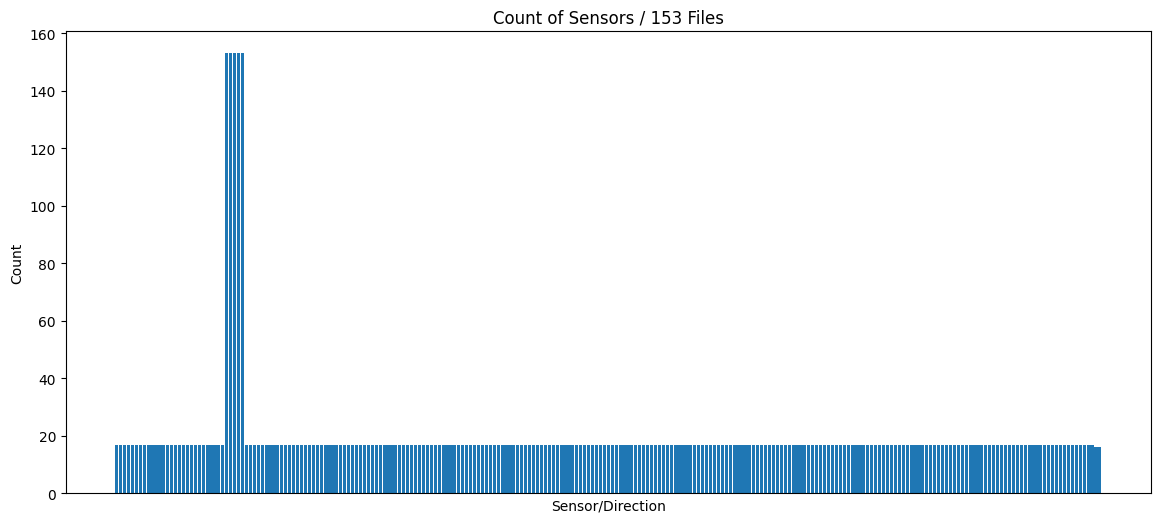

Total number of observations using only always working sensors
3060.0


In [318]:
# visualize sensor failure
keys = list(counter.keys())
values = list(counter.values())
plt.figure(figsize=(14, 6))
# generate bar plot
plt.bar(keys, values)

# labels and title
plt.xticks([])
plt.xlabel('Sensor/Direction')
plt.ylabel('Count')
plt.title('Count of Sensors / 153 Files')

plt.show()

print("Total number of observations using only always working sensors")
print(5*((SIGLEN)/16384.0)*153)

### Most reliable sensors are R1V, R2L, R2T, R2V, R3V, which are present in every acquisition file. Any of these can be used as reference sensor.
#### Baseline reference sensor is chosen to be R1V

### - According to Martakis et al, the transmissibility can be calculated as  
$$ T_{A,B} = \frac{|X_A(f)| \times |X_B(f)|}{|X_B(f)| \times |X_B(f)|}$$
which measures how much the signal gets distorted or transmitted between points A and B. $X_A(f)$ denotes the fourier transform at sensor A. In this case, R1V is sensor B.

In [279]:
import numpy as np

def tac(Tr, Td):
    """
    Calculate the Transmissibility Assurance Criterion (TAC) based on
    given transmissibility vectors in reference (Tr) and damaged (Td) states.

    Parameters:
        Tr (numpy.ndarray): Transmissibility vector in reference state
        Td (numpy.ndarray): Transmissibility vector in damaged state

    Returns:
        float: The Transmissibility Assurance Criterion (TAC)
    """
    # Calculate the numerator
    numerator = np.abs(np.dot(np.conjugate(Td), Tr)) ** 2
    
    # Calculate the denominator
    denominator = np.dot(np.conjugate(Td), Td) * np.dot(np.conjugate(Tr), Tr)
    
    # Calculate TAC
    ans = numerator / denominator
    
    return ans

In [280]:
def transmissibility(root, window_size = 16384, train = True, train_split = 0.2):
    """
    window_size: length of a subdivision of original signal (6000 samples * (1/100) seconds/samples = 60 second sample)
    train: if True, then get training portion of data
    train_split: what proportion to use as training data (by default one third)
    """
    from scipy.io import loadmat
    signals = []
    folder_path = root
    file_list = os.listdir(folder_path)
    sensors = []

    # for determinism
    random.seed(10)
    
    # walk inside data folder
    for filename in file_list:
        full_path = os.path.join(folder_path, filename)
        cur_label = int(filename)

        # walk inside data/[number]
        file_nest_list = os.listdir(full_path)
        for filename_1 in file_nest_list:
            if filename_1 != "avt":
                continue
            else:
                # full_path_2 is of the form C:\Users\amroa\Documents\thesis\data\01\avt
                full_path_2 = os.path.join(full_path, filename_1)
                setup_filenames = [filename for filename in os.listdir(full_path_2) if "setup" in filename]
                if train:
                    # take train_split percent of data
                    train_files = setup_filenames[0:int(len(setup_filenames)*train_split)]

                    # iterate through them
                    for file_train in train_files:
                        full_path_3 = os.path.join(full_path_2, file_train) # full_path_3 is of the form C:\Users\amroa\Documents\thesis\data\01\avt\01setup09.mat
                        
                        avt = loadmat(full_path_3)
                        avt_t = avt['data'].transpose()

                        # pad every signal to length 65536
                        padded_avt = [np.pad(arr, (0, SIGLEN - len(arr)), 'constant') for arr in avt_t]
                        avt_t = padded_avt

                        # make sure to divide by the reference signal
                        ref_loc = list(avt['labelshulp']).index("R1V ")

                        # split the signal into smaller signals of sample size window_size 
                        windows = [windowize(avt_t[i], int(SIGLEN/window_size)) for i in range(len(avt_t))] # list of lists

                        Xf = np.array([[np.abs(fft(i))[:int(window_size//2)] for i in window] for window in windows])

                        # Reference amplitude
                        reference_amplitude = Xf[ref_loc]
                        transmissibility = Xf/reference_amplitude

                        # append new transmissibility signals and labels
                        [[(signals.append(i), sensors.append( avt['labelshulp'][idx] )) for i in window] for idx, window in enumerate(transmissibility)] 
                else:
                    # take test_split percent of data
                    test_files = setup_filenames[int(len(setup_filenames)*train_split):]

                    # iterate through them
                    for file_test in test_files:
                        full_path_3 = os.path.join(full_path_2, file_test) # full_path_3 is of the form C:\Users\amroa\Documents\thesis\data\01\avt\01setup09.mat
                        
                        avt = loadmat(full_path_3)
                        avt_t = avt['data'].transpose()

                        # pad every signal to length 65536
                        padded_avt = [np.pad(arr, (0, SIGLEN - len(arr)), 'constant') for arr in avt_t]
                        avt_t = padded_avt

                        # make sure to divide by the reference signal
                        ref_loc = list(avt['labelshulp']).index("R1V ")

                        # split the signal into smaller signals of sample size window_size 
                        windows = [windowize(avt_t[i], int(SIGLEN/window_size)) for i in range(len(avt_t))] # list of lists

                        Xf = np.array([[np.abs(fft(i))[:int(window_size//2)] for i in window] for window in windows])

                        # Reference amplitude
                        reference_amplitude = Xf[ref_loc]
                        transmissibility = Xf/reference_amplitude 

                        # append new transmissibility signals and labels
                        [[(signals.append(i), sensors.append( avt['labelshulp'][idx] )) for i in window] for idx, window in enumerate(transmissibility)]

    # sensors is the same length as signals. The ith entry in sensors describes which sensor was used to obtain the ith signal in signals
    return signals, sensors


In [281]:
trans_signals, sensors = transmissibility('C:\\Users\\amroa\\Documents\\thesis\\data', window_size = 16384, train = True, train_split = 0.5)
print(len(trans_signals))
print(len(sensors))

8976
8976


## Feature Engineering: Feature vector computation over acceleration signals

In [290]:
# preprocess the signals
preprocessed_sigs = np.array([preprocess(sig) for sig in signals])

# get time domain features
X_train_time =  np.apply_along_axis(time_domain_characteristics, axis = 1, arr = preprocessed_sigs) 

# get freq domain features
X_train_freq =  np.apply_along_axis(frequency_domain_characteristics, axis = 1, arr = preprocessed_sigs) 

# horizontally concat everything
X_train_unstd = np.hstack((X_train_time, X_train_freq, np.array(trans_signals)))

In [291]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unstd)

In [292]:
pca = PCA(n_components=2) 
X_train_2D = pca.fit_transform(X_train)

## Visualization: PCA, TSNE

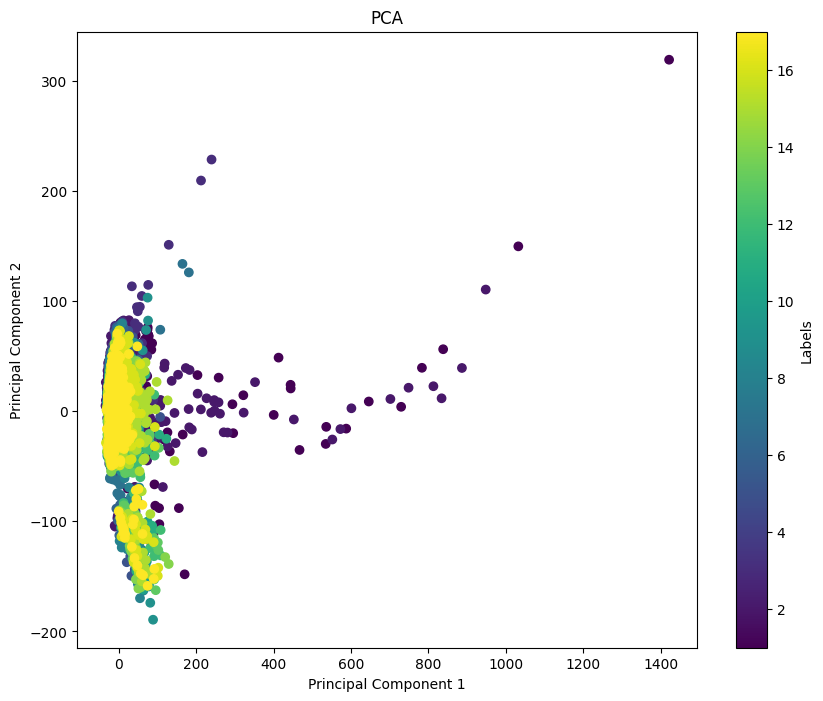

In [293]:
# create figure and axes object
fig, ax1 = plt.subplots(figsize=(10, 8))

# scatter plot for PCA
sc = ax1.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=labels, cmap='viridis')
ax1.set_title("PCA")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
cbar = plt.colorbar(sc, ax=ax1)
cbar.set_label('Labels')

# display the plot
plt.show()

In [294]:
# do 2-dimensional t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=250)
tsne_results = tsne.fit_transform(X_train)

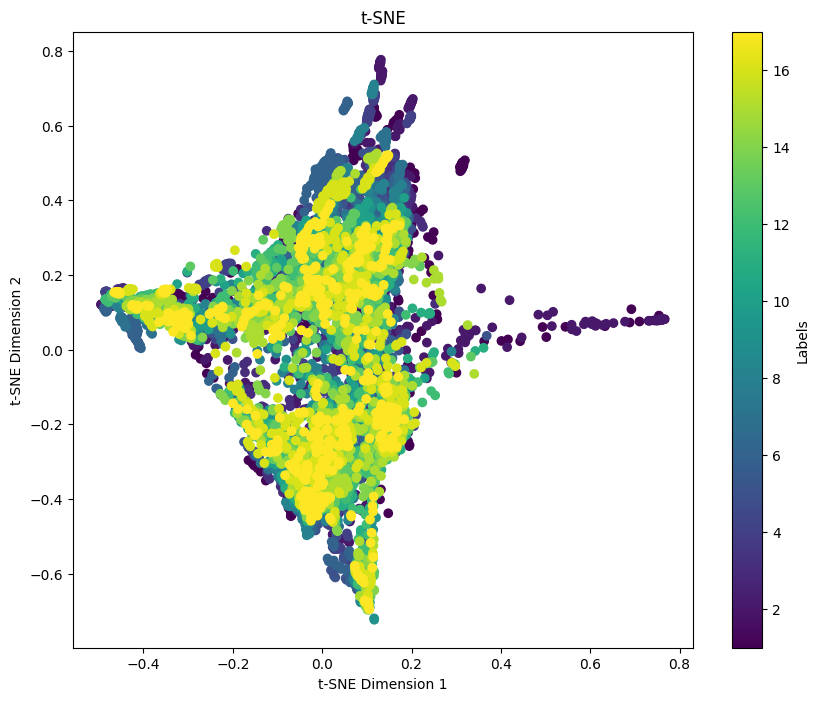

In [295]:
# create figure and axes object
fig, ax1 = plt.subplots(figsize=(10, 8))

# scatter plot for PCA
sc = ax1.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
ax1.set_title("t-SNE")
ax1.set_xlabel("t-SNE Dimension 1")
ax1.set_ylabel("t-SNE Dimension 2")
cbar = plt.colorbar(sc, ax=ax1)
cbar.set_label('Labels')

# display the plot
plt.show()

## Feature importance

#### - Using random forest

In [317]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, np.array(labels) - 1)
importances = clf.feature_importances_

In [302]:
top_10_importances = sorted(enumerate(importances), key=lambda x: x[1], reverse=True)[:10]

for idx, importance in top_10_importances:
    print(f"Index: {idx}, Importance: {importance}")

Index: 16398, Importance: 0.0013393912664338998
Index: 618, Importance: 0.0010219868070532935
Index: 614, Importance: 0.0009438621230408494
Index: 613, Importance: 0.0009127848772528105
Index: 628, Importance: 0.0008595755551059235
Index: 18451, Importance: 0.0007575258956110476
Index: 141, Importance: 0.0007564735412895052
Index: 627, Importance: 0.0007303179501725644
Index: 621, Importance: 0.0007004705345181389
Index: 18519, Importance: 0.0006805395973656931


#### - Using XGBoost

In [304]:
import xgboost as xgb

# create XGBoost model and fit it
model = xgb.XGBRegressor()
model.fit(X_train, np.array(labels) - 1)
importances = model.feature_importances_

In [305]:
top_10_importances = sorted(enumerate(importances), key=lambda x: x[1], reverse=True)[:10]

for idx, importance in top_10_importances:
    print(f"Index: {idx}, Importance: {importance}")

Index: 18467, Importance: 0.07679706066846848
Index: 18475, Importance: 0.048744089901447296
Index: 18470, Importance: 0.03733798861503601
Index: 18716, Importance: 0.03729884326457977
Index: 18742, Importance: 0.03338511288166046
Index: 18276, Importance: 0.029039407148957253
Index: 18765, Importance: 0.022717218846082687
Index: 653, Importance: 0.016607943922281265
Index: 598, Importance: 0.016457995399832726
Index: 18466, Importance: 0.015406596474349499


In [307]:
X_train_freq.shape

(8976, 16388)

### Conclusion: Random forest gives *most* importance to a scalar in the transmissibility feature vector and then gives frequency domain features more importance, whereas XGBoost consistently gives importance to transmissibility with frequency domain only coming 8th and 9th in importance